# GLM: Poisson Regression

In [1]:
import aesara
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

from formulae import design_matrices

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

This is a minimal reproducible example of Poisson regression to predict counts using dummy data.

This Notebook is basically an excuse to demo Poisson regression using PyMC, both manually and using `bambi` to demo interactions using the `formulae` library. We will create some dummy data, Poisson distributed according to a linear model, and try to recover the coefficients of that linear model through inference.

For more statistical detail see:

+ Basic info on [Wikipedia](https://en.wikipedia.org/wiki/Poisson_regression)
+ GLMs: Poisson regression, exposure, and overdispersion in Chapter 6.2 of [ARM, Gelmann & Hill 2006](http://www.stat.columbia.edu/%7Egelman/arm/)
+ This worked example from ARM 6.2 by [Clay Ford](http://www.clayford.net/statistics/poisson-regression-ch-6-of-gelman-and-hill/)

This very basic model is inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerned with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.

## Local Functions

## Generate Data

This dummy dataset is created to emulate some data created as part of a study into quantified self, and the real data is more complicated than this. Ask Ian Osvald if you'd like to know more https://twitter.com/ianozsvald


### Assumptions:

+ The subject sneezes N times per day, recorded as `nsneeze (int)`
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as the negative action `nomeds (boolean)`
+ We postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increased after alcohol is consumed.
+ The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for alcohol and antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.


Create 4000 days of data: daily counts of sneezes which are Poisson distributed w.r.t alcohol consumption and antihistamine usage

In [3]:
# decide poisson theta values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                rng.poisson(theta_noalcohol_meds, q),
                rng.poisson(theta_alcohol_meds, q),
                rng.poisson(theta_noalcohol_nomeds, q),
                rng.poisson(theta_alcohol_nomeds, q),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(False, q),
                np.repeat(True, q),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(True, q),
            )
        ),
    }
)

In [4]:
df.tail()

,nsneeze,alcohol,nomeds
3995,26,True,True
3996,35,True,True
3997,36,True,True
3998,32,True,True
3999,35,True,True


##### View means of the various combinations (Poisson mean values)

In [5]:
df.groupby(["alcohol", "nomeds"]).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     1.047   5.981
True      2.986  35.929

### Briefly Describe Dataset

/home/ada/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


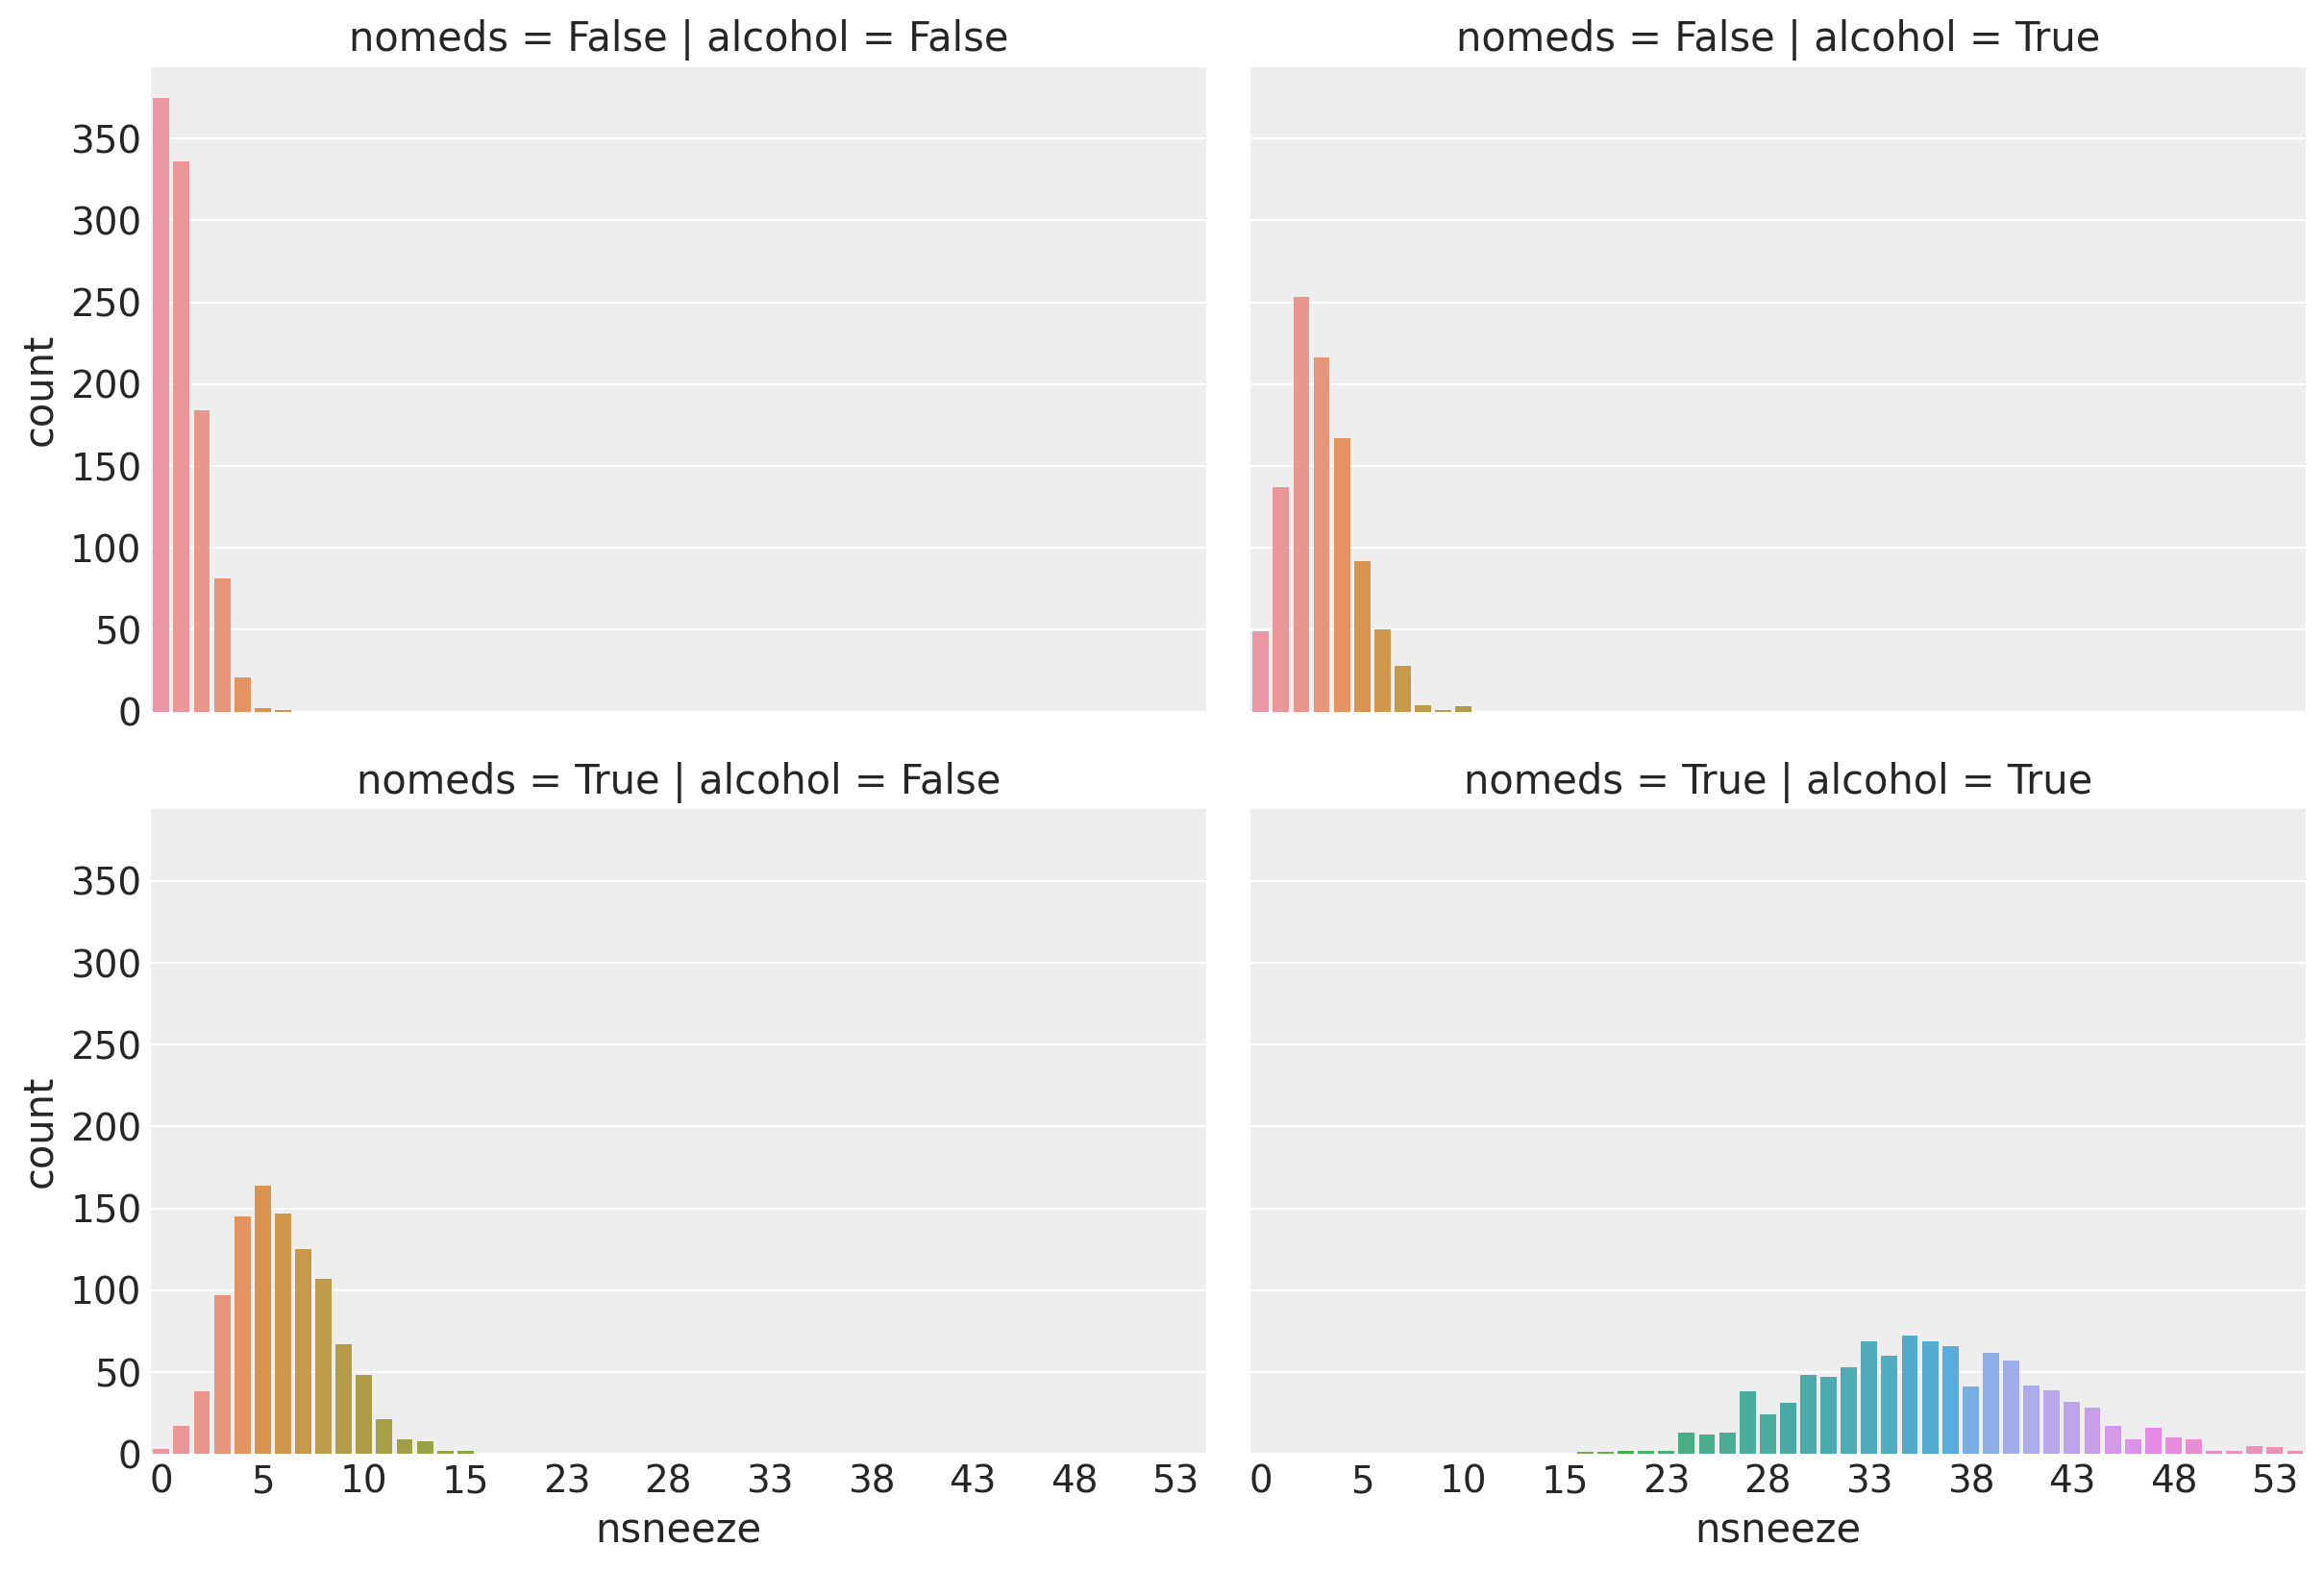

In [6]:
g = sns.catplot(
    x="nsneeze",
    row="nomeds",
    col="alcohol",
    data=df,
    kind="count",
    height=4,
    aspect=1.5,
)
for ax in (g.axes[1, 0], g.axes[1, 1]):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        label.set_visible(n % 5 == 0)

**Observe:**

+ This looks a lot like poisson-distributed count data (because it is)
+ With `nomeds == False` and `alcohol == False` (top-left, akak antihistamines WERE used, alcohol was NOT drunk) the mean of the poisson distribution of sneeze counts is low.
+ Changing `alcohol == True` (top-right) increases the sneeze count `nsneeze` slightly
+ Changing `nomeds == True` (lower-left) increases the sneeze count `nsneeze` further
+ Changing both `alcohol == True and nomeds == True` (lower-right) increases the sneeze count `nsneeze` a lot, increasing both the mean and variance.

---

## Poisson Regression

Our model here is a very simple Poisson regression, allowing for interaction of terms:

$$ \theta = exp(\beta X)$$

$$ Y_{sneeze\_count} \sim Poisson(\theta)$$

**Create linear model for interaction of terms**

In [7]:
fml = "nsneeze ~ alcohol + nomeds + alcohol:nomeds"  # full formulae formulation

In [8]:
fml = "nsneeze ~ alcohol * nomeds"  # lazy, alternative formulae formulation

### 1. Manual method, create design matrices and manually specify model

**Create Design Matrices**

In [9]:
dm = design_matrices(fml, df, na_action="error")

In [10]:
mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

In [11]:
mx_ex

,Intercept,alcohol,nomeds,alcohol:nomeds
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
3995,1.0,1.0,1.0,1.0
3996,1.0,1.0,1.0,1.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0


**Create Model**

In [12]:
with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=10)
    b1 = pm.Normal("alcohol", mu=0, sigma=10)
    b2 = pm.Normal("nomeds", mu=0, sigma=10)
    b3 = pm.Normal("alcohol:nomeds", mu=0, sigma=10)

    # define linear model and exp link function
    theta = b0 + b1 * mx_ex["alcohol"] + b2 * mx_ex["nomeds"] + b3 * mx_ex["alcohol:nomeds"]

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=np.exp(theta), observed=mx_en["nsneeze"].values)

**Sample Model**

In [13]:
with mdl_fish:
    inf_fish = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol:nomeds, nomeds, alcohol, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


**View Diagnostics**

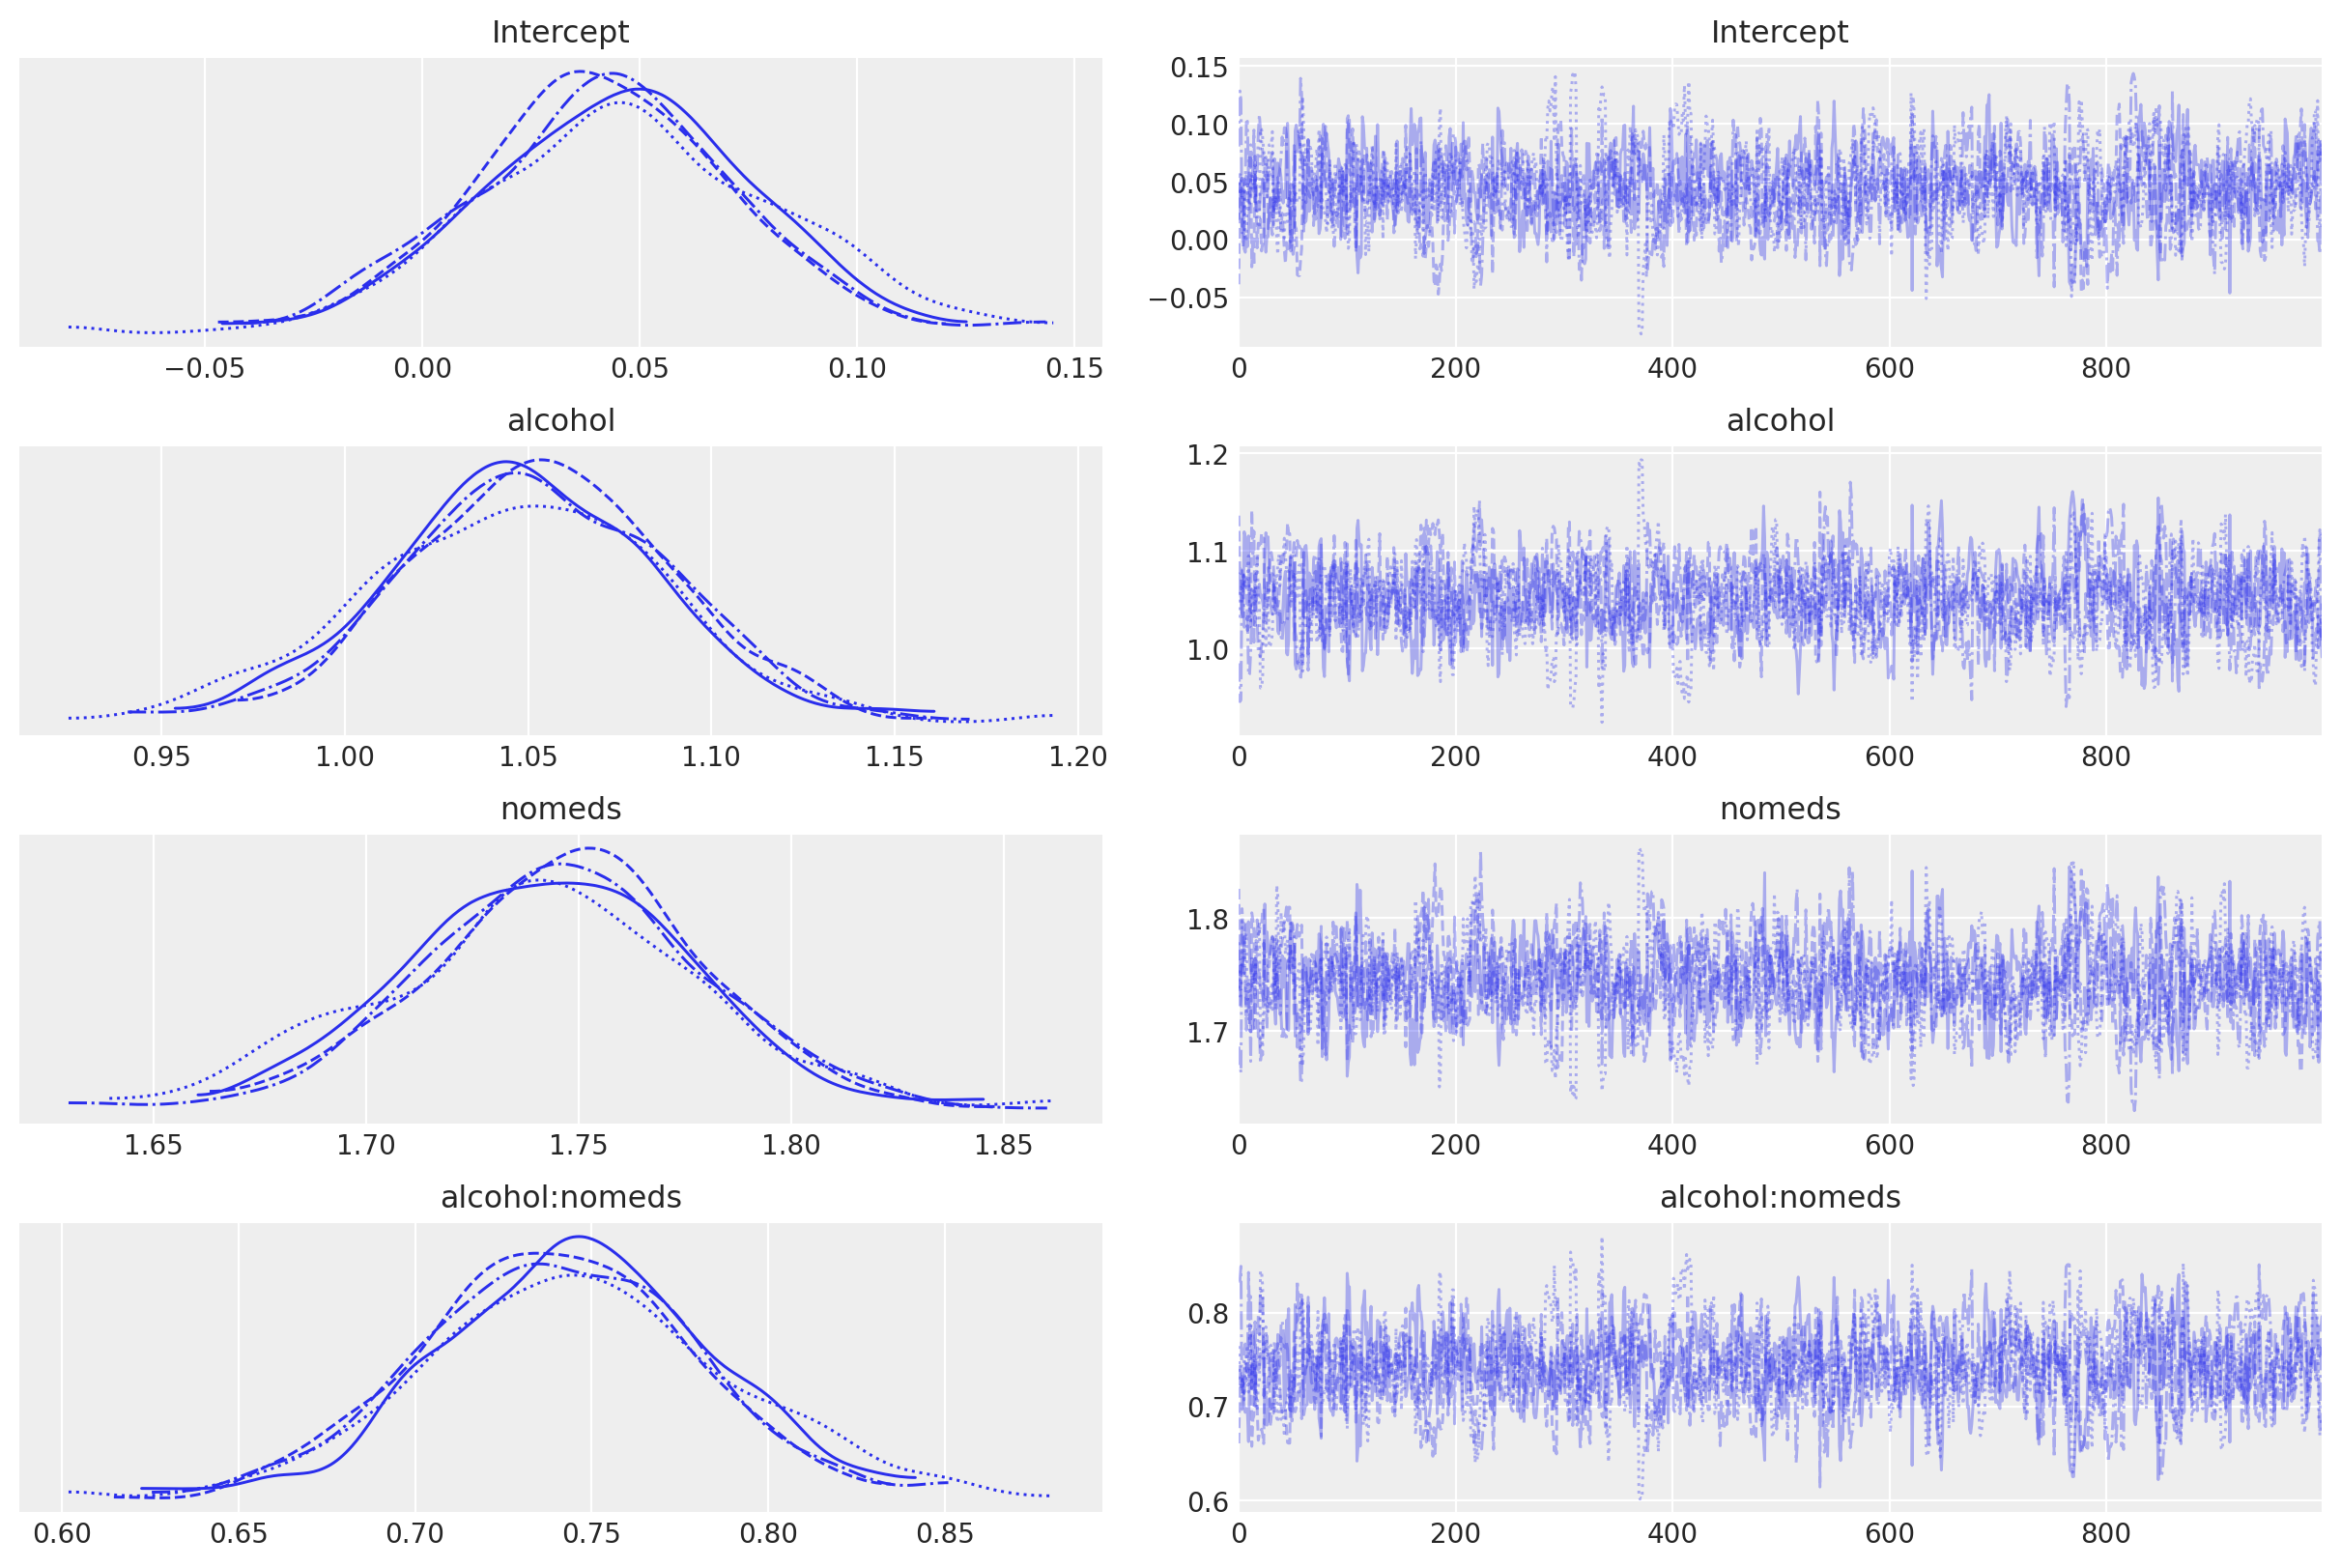

In [14]:
az.plot_trace(inf_fish);

**Observe:**

+ The model converges quickly and traceplots looks pretty well mixed

### Transform coeffs and recover theta values

In [15]:
az.summary(np.exp(inf_fish.posterior), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,1.046,0.033,0.982,1.105
alcohol,2.860,0.105,2.668,3.066
nomeds,5.726,0.196,5.344,6.082
alcohol:nomeds,2.103,0.083,1.964,2.281


**Observe:**

+ The contributions from each feature as a multiplier of the baseline sneezecount appear to be as per the data generation:
    
    
    1. exp(Intercept): mean=1.05  cr=[0.98, 1.10]        
    
        Roughly linear baseline count when no alcohol and meds, as per the generated data: 

        theta_noalcohol_meds = 1 (as set above)
        theta_noalcohol_meds = exp(Intercept) 
                             = 1


    2. exp(alcohol): mean=2.86  cr=[2.67, 3.07]
    
        non-zero positive effect of adding alcohol, a ~3x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_meds = 3 (as set above)
        theta_alcohol_meds = exp(Intercept + alcohol) 
                           = exp(Intercept) * exp(alcohol) 
                           = 1 * 3 = 3


    3. exp(nomeds): mean=5.73  cr=[5.34, 6.08]    
    
        larger, non-zero positive effect of adding nomeds, a ~6x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_noalcohol_nomeds = 6 (as set above)
        theta_noalcohol_nomeds = exp(Intercept + nomeds)
                               = exp(Intercept) * exp(nomeds) 
                               = 1 * 6 = 6
    
    
    4. exp(alcohol:nomeds): mean=2.10  cr=[1.96, 2.28]
    
        small, positive interaction effect of alcohol and meds, a ~2x multiplier of 
        baseline sneeze count, as per the generated data: 

        theta_alcohol_nomeds = 36 (as set above)
        theta_alcohol_nomeds = exp(Intercept + alcohol + nomeds + alcohol:nomeds)
                             = exp(Intercept) * exp(alcohol) * exp(nomeds * alcohol:nomeds)
                             = 1 * 3 * 6 * 2 = 36

### 2. Alternative method, using `bambi`

**Create Model**

**Alternative automatic formulation using `bambi`**

In [16]:
model = bmb.Model(fml, df, family="poisson")

**Fit Model**

In [17]:
inf_fish_alt = model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol:nomeds, nomeds, alcohol, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.


**View Traces**

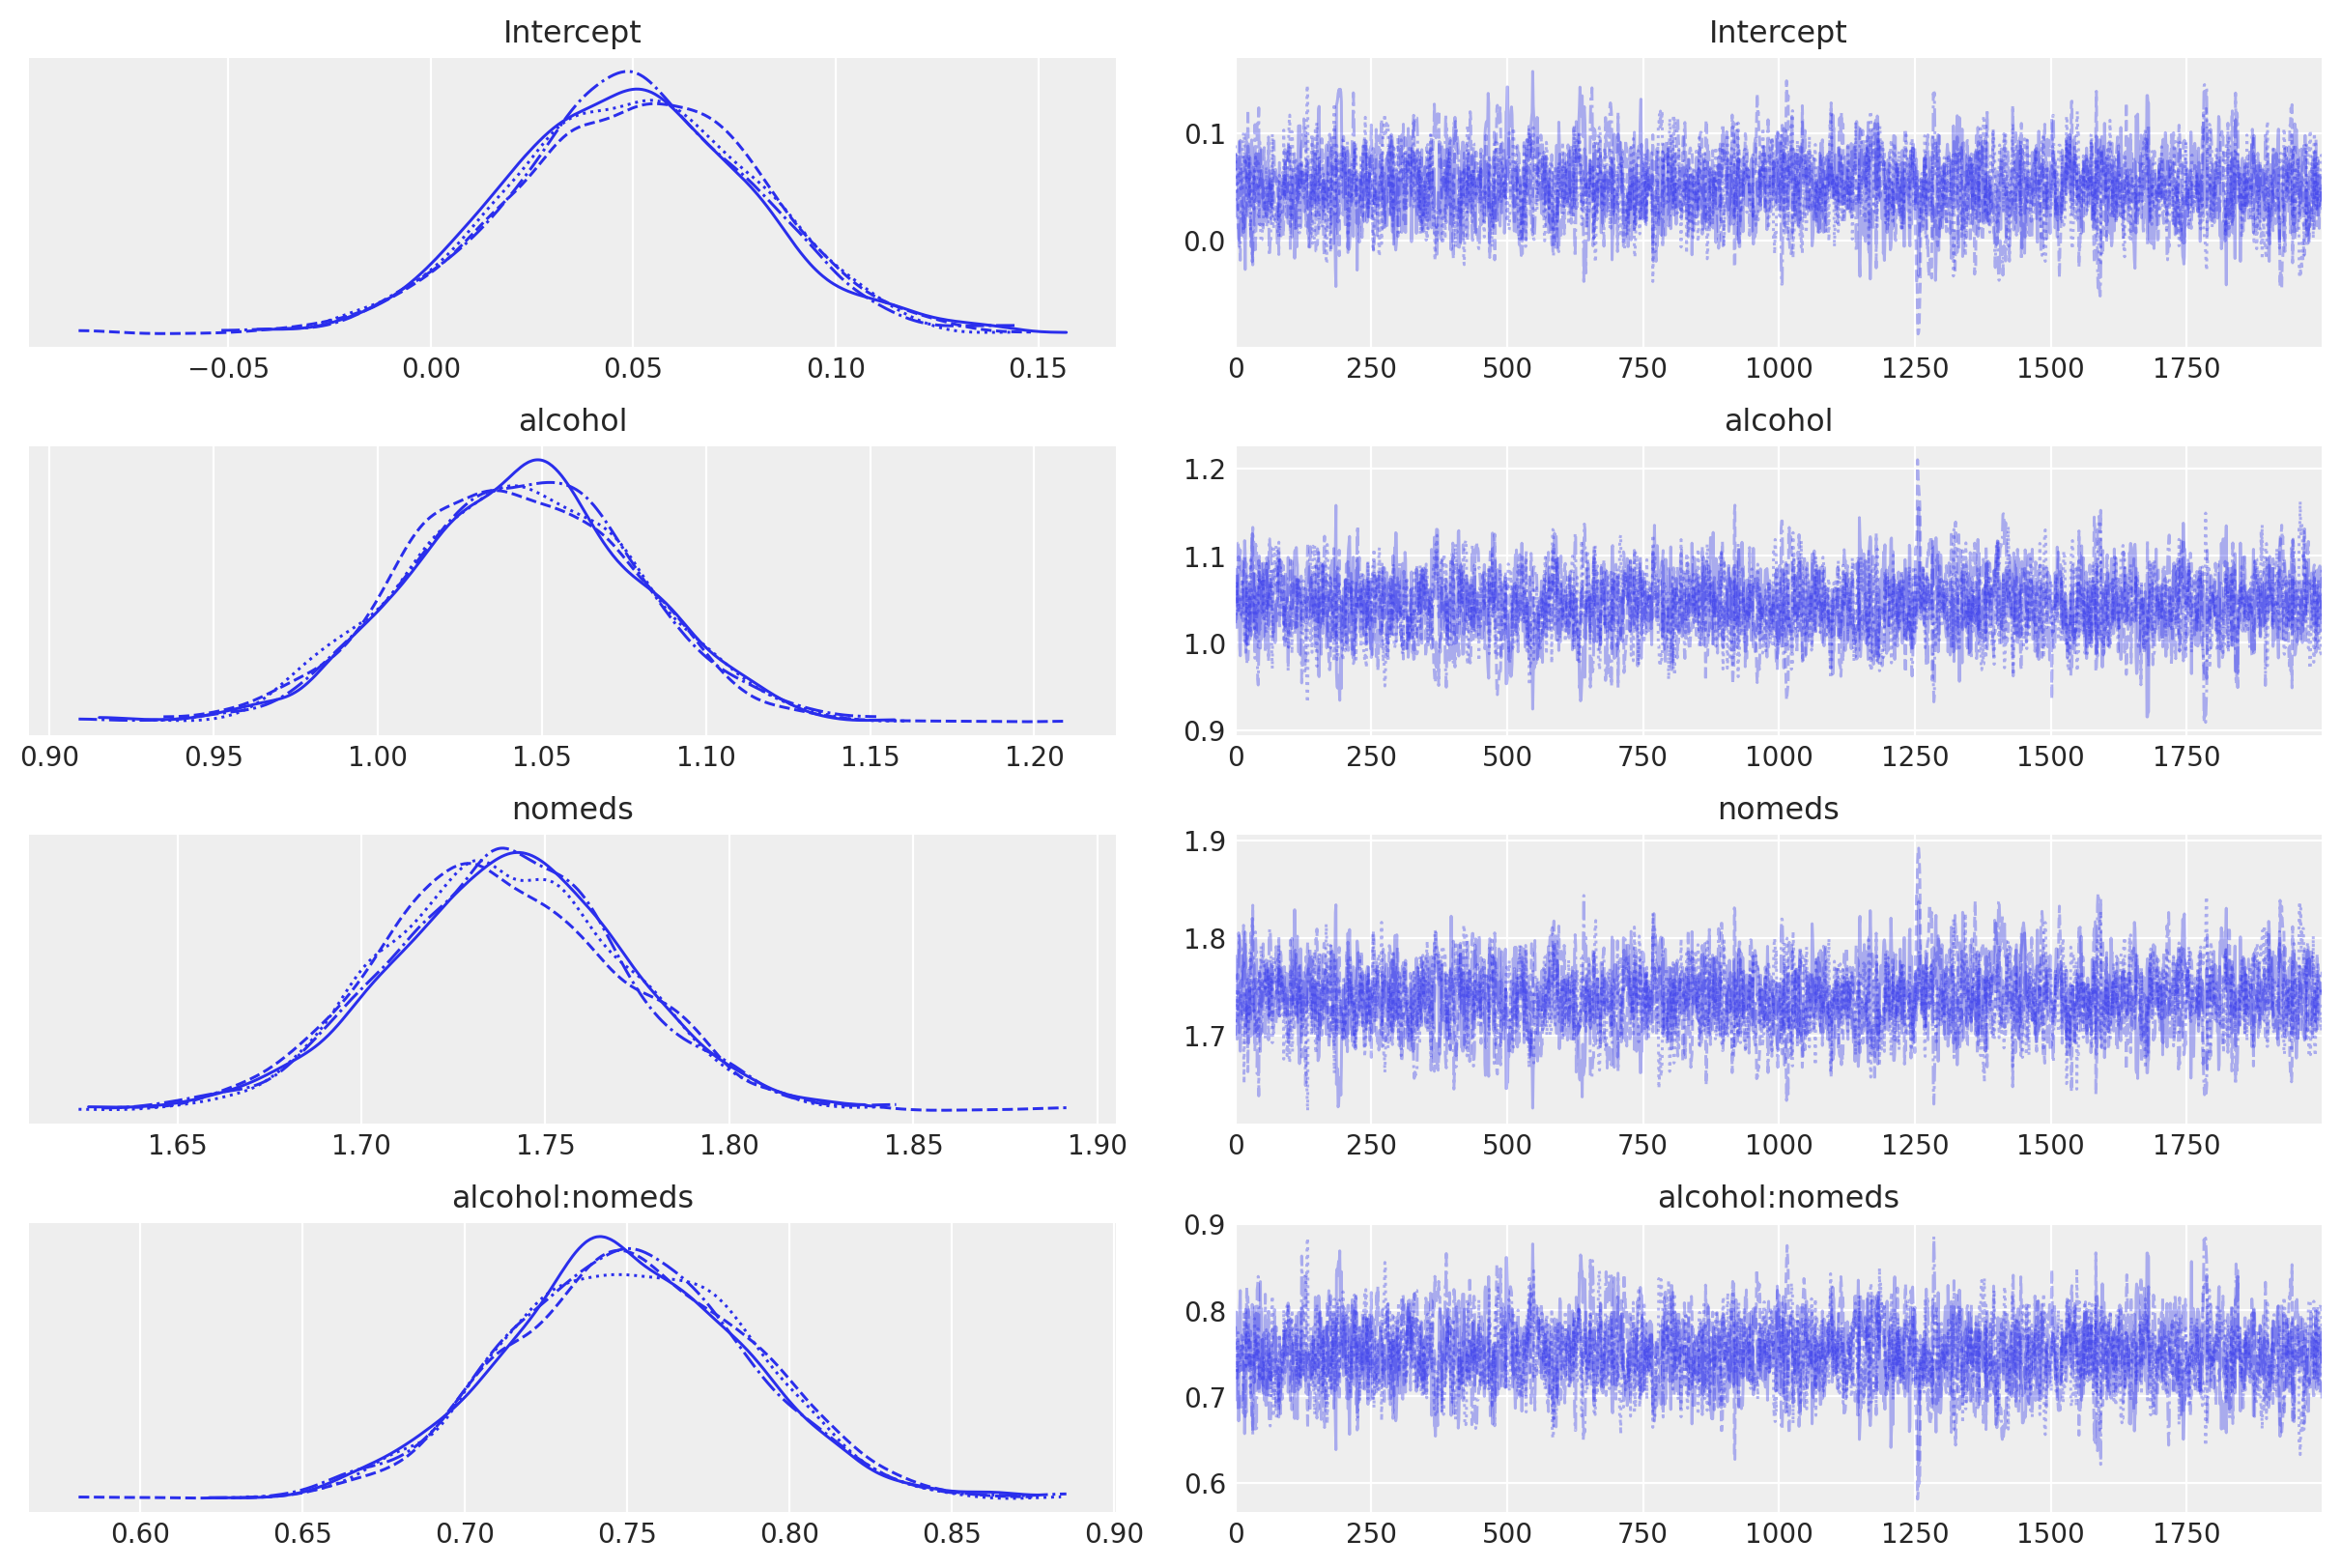

In [18]:
az.plot_trace(inf_fish_alt);

### Transform coeffs

In [19]:
az.summary(np.exp(inf_fish_alt.posterior), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,1.052,0.032,0.993,1.111
alcohol,2.841,0.100,2.657,3.028
nomeds,5.692,0.186,5.357,6.047
alcohol:nomeds,2.118,0.080,1.967,2.263


**Observe:**

+ The traceplots look well mixed
+ The transformed model coeffs look moreorless the same as those generated by the manual model
+ Note that the posterior predictive samples have an extreme skew

In [20]:
model.posterior_predictive(inf_fish_alt, draws=None)

We can use `az.plot_ppc()` to check that the posterior predictive samples are similar to the observed data.

For more information on posterior predictive checks, we can refer to https://docs.pymc.io/notebooks/posterior_predictive.html.

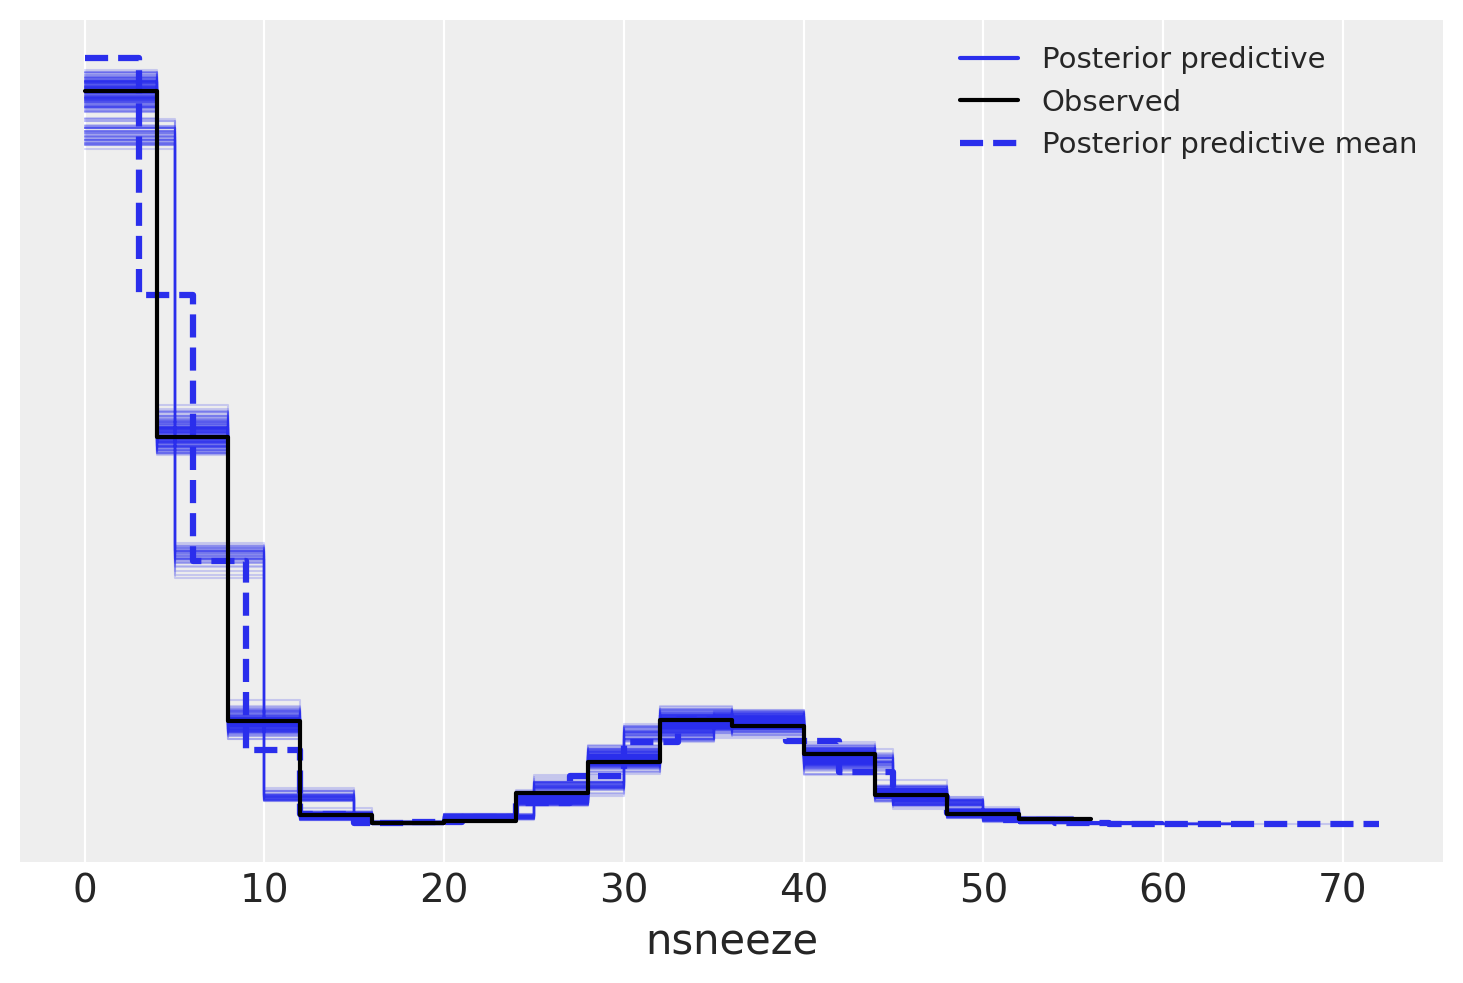

In [21]:
az.plot_ppc(inf_fish_alt, num_pp_samples=200);

---
Example originally contributed by Jonathan Sedar 2016-05-15 [github.com/jonsedar](https://github.com/jonsedar)

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jul 20 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

matplotlib: 3.3.4
aesara    : 1.1.2
numpy     : 1.21.0
seaborn   : 0.11.1
xarray    : 0.17.0
pandas    : 1.2.1
bambi     : 0.5.0
arviz     : 0.11.2
pymc     : 3.11.2

Watermark: 2.2.0

